<a href="https://colab.research.google.com/github/eutiagovski/data-science/blob/main/PRO4-Visao_Computacional.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### OBJETIVO

O objetivo deste trabalho é utilizar um rede neural treinada aliada a um selective search para detectar se há um cachorro em uma imagem.

In [ ]:
# import the necessary packages
from google.colab.patches import cv2_imshow
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.preprocessing.image import img_to_array
from imutils.object_detection import non_max_suppression
from datetime import datetime
from tensorflow import keras
import numpy as np
import argparse
import cv2

### METODOLOGIA

* realizamos um grid search em toda a imagem em busca das regiões de interesse
* cada região de interese gerada é então passada para o modelo criado na última aula treinado com a base cifar10
* as previsões relizadas são agrudapas de acordo com a previsão da sua categoria. 
* as regiões que não foram classificadas como cachorro são ignoradas.
* as regiões classificadas como cachorro são então suprimidas para gerar uma grande região de interesse 
* a imagem então é exibida e se houver um cachorro, existirá uma bounding box com a sua localização

In [ ]:
# Esta classe é uma adapção do artigo abaixo
# https://pyimagesearch.com/2020/07/13/r-cnn-object-detection-with-keras-tensorflow-and-deep-learning/


class ImageHasDog:
  def __init__(self, model, method):
    self.model = model
    self.method = method
  
  def selective_search(self):
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    ss.setBaseImage(self.image)
    if self.method == "fast":
      ss.switchToSelectiveSearchFast()
    else:
      ss.switchToSelectiveSearchQuality()
    rects = ss.process()
    self.rects = rects
    return rects
  def load_model(self):
    print("[INFO] loading my model...")
    self.model = self.model

  def search_dog(self, image):
    print("[INFO] starting dog's classifier...")
    start = datetime.now()
    self.image = cv2.imread(image)
    (self.H, self.W) = self.image.shape[:2]
    self.load_model()
    print("[INFO] performing selective search with '{}' method...".format(
      self.method))
    
    rects = self.selective_search()
    print("[INFO] {} regions found by selective search".format(len(rects)))
    proposals = []
    boxes = []

    for (x, y, w, h) in rects:
      if w / float(self.W) < 0.1 or h / float(self.H) < 0.1:
        continue
      roi = self.image[y:y + h, x:x + w]
      roi = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
      roi = cv2.resize(roi, (32, 32))
      roi = img_to_array(roi)
      roi = preprocess_input(roi)
      proposals.append(roi)
      boxes.append((x, y, w, h))

    proposals = np.array(proposals)
    print("[INFO] proposal shape: {}".format(proposals.shape))
    print("[INFO] classifying proposals...")
    preds = model.predict(proposals)
    labels = {}

    list_preds = [];

    for i in range(len(preds)):
      list_preds.append((i, esqueci_as_classes_me_ajuda(preds[i]), 1))

    preds = list_preds

    for (i, p) in enumerate(preds):
      (imagenetID, label, prob) = p
      if label == 'dog':
        (x, y, w, h) = boxes[i]
        box = (x, y, x + w, y + h)
        L = labels.get(label, [])
        L.append((box, prob))
        labels[label] = L
    
    label = 'dog'
    
    print("[INFO] showing results for '{}'".format(label))
    clone = self.image.copy()
    if labels:
      boxes = np.array([p[0] for p in labels[label]])
      proba = np.array([p[1] for p in labels[label]])
      boxes = non_max_suppression(boxes, proba)
      for (startX, startY, endX, endY) in boxes:
        cv2.rectangle(clone, (startX, startY), (endX, endY),
          (0, 255, 0), 2)
        y = startY - 10 if startY - 10 > 10 else startY + 10
        cv2.putText(clone, label, (startX, y),
          cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 2)
        break
    time_delta = datetime.now() - start
    print("[INFO] took {} seconds".format(time_delta.seconds))
    cv2_imshow(clone)
    cv2.waitKey(0)

### DESENVOLVIMENTO


In [ ]:
# Carregando o modelo treinado da última aula

def esqueci_as_classes_me_ajuda(pred):
  dicionario = {0: "airplane",
           1: "automobile",
           2: "bird",
           3: "cat",
           4: "deer",
           5: "dog",
           6: "frog",
           7: "horse",
           8: "ship",
           9: "truck"}
  return dicionario[np.argmax(pred)]


In [ ]:
# modelo da útima aula, disponível em: https://colab.research.google.com/drive/1N1IEhfs33IAlrUysCSVNUtQLZ2X2jpCf

model = keras.models.load_model('/content/drive/MyDrive/Mentorama/modelos_treinados/cifar10')

In [ ]:
# instanciando a classe criada

image_has_dog = ImageHasDog

[INFO] starting dog's classifier...
[INFO] loading my model...
[INFO] performing selective search with 'fast' method...
[INFO] 1708 regions found by selective search
[INFO] proposal shape: (543, 32, 32, 3)
[INFO] classifying proposals...
[INFO] showing results for 'dog'
[INFO] took 4seconds


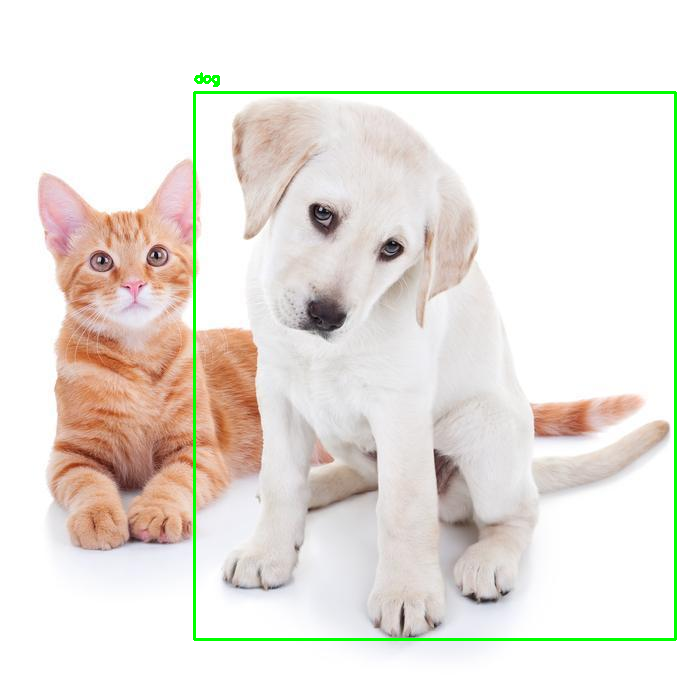

In [ ]:
# aplicando a imagem ao modelo e obtendo os resultados
# imagem_1 = 'https://www.peritoanimal.com.br/apresentar-um-cao-a-um-gato-corretamente-21162.html'

dog_clf = image_has_dog(model=model, method='fast')
dog_clf.search_dog('apresentar_um_cao_a_um_gato_corretamente_21162_orig.jpg')

[INFO] starting dog's classifier...
[INFO] loading my model...
[INFO] performing selective search with 'quality' method...
[INFO] 5031 regions found by selective search
[INFO] proposal shape: (1909, 32, 32, 3)
[INFO] classifying proposals...
[INFO] showing results for 'dog'
[INFO] took 15seconds


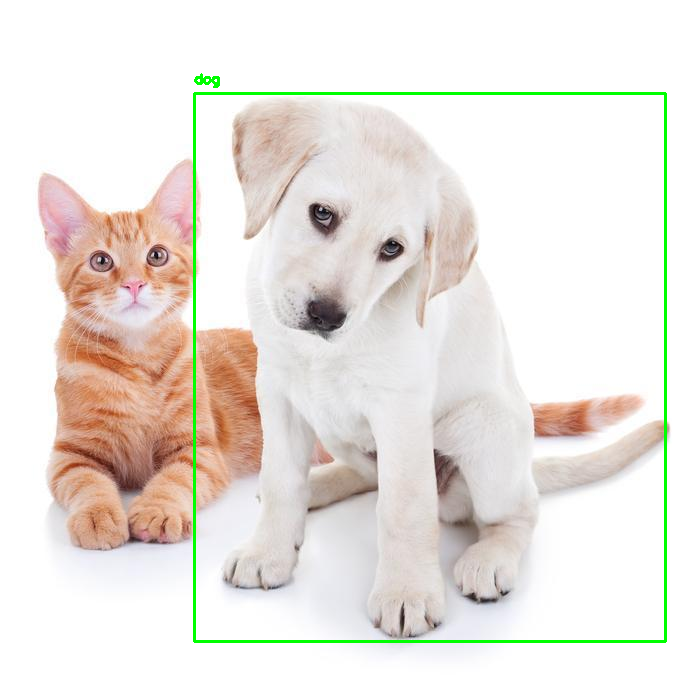

In [ ]:
dog_clf = image_has_dog(model=model, method='quality')
dog_clf.search_dog('apresentar_um_cao_a_um_gato_corretamente_21162_orig.jpg')

[INFO] starting dog's classifier...
[INFO] loading my model...
[INFO] performing selective search with 'fast' method...
[INFO] 1666 regions found by selective search
[INFO] proposal shape: (671, 32, 32, 3)
[INFO] classifying proposals...
[INFO] showing results for 'dog'
[INFO] took 3seconds


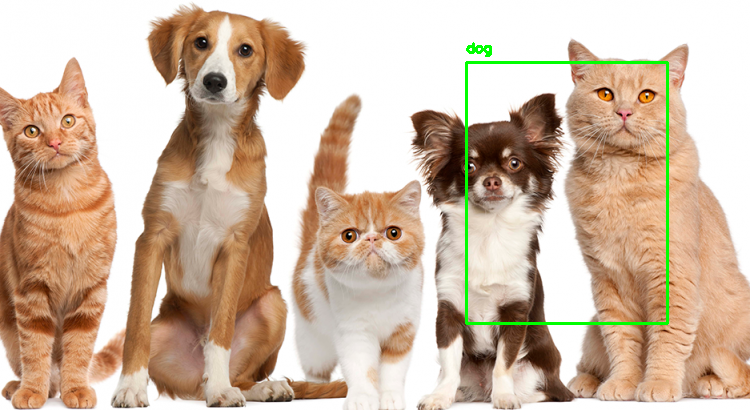

In [ ]:
# imagem_2 = 'https://chacarapet.com.br/blog/wp-content/uploads/2020/06/gato-e-cachorro-juntos-750x410.png'

dog_clf = image_has_dog(model=model, method='fast')
dog_clf.search_dog('gato-e-cachorro-juntos-750x410.png')

[INFO] starting dog's classifier...
[INFO] loading my model...
[INFO] performing selective search with 'quality' method...
[INFO] 6931 regions found by selective search
[INFO] proposal shape: (3211, 32, 32, 3)
[INFO] classifying proposals...
[INFO] showing results for 'dog'
[INFO] took 12seconds


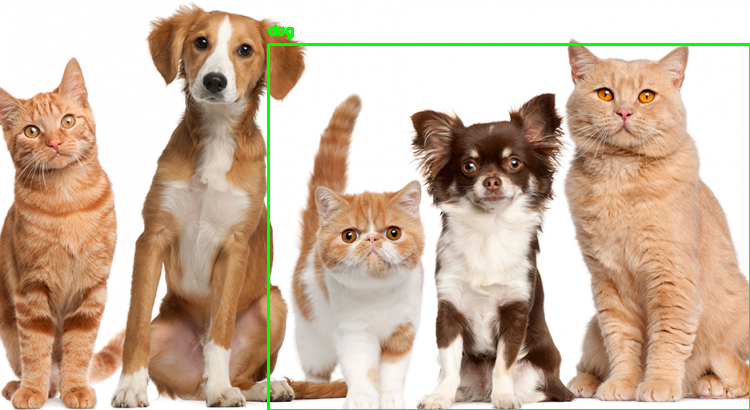

In [ ]:
# imagem_2 = 'https://chacarapet.com.br/blog/wp-content/uploads/2020/06/gato-e-cachorro-juntos-750x410.png'

dog_clf = image_has_dog(model=model, method='quality')
dog_clf.search_dog('gato-e-cachorro-juntos-750x410.png')

[INFO] starting dog's classifier...
[INFO] loading my model...
[INFO] performing selective search with 'fast' method...
[INFO] 3592 regions found by selective search
[INFO] proposal shape: (760, 32, 32, 3)
[INFO] classifying proposals...
[INFO] showing results for 'dog'
[INFO] took 13seconds


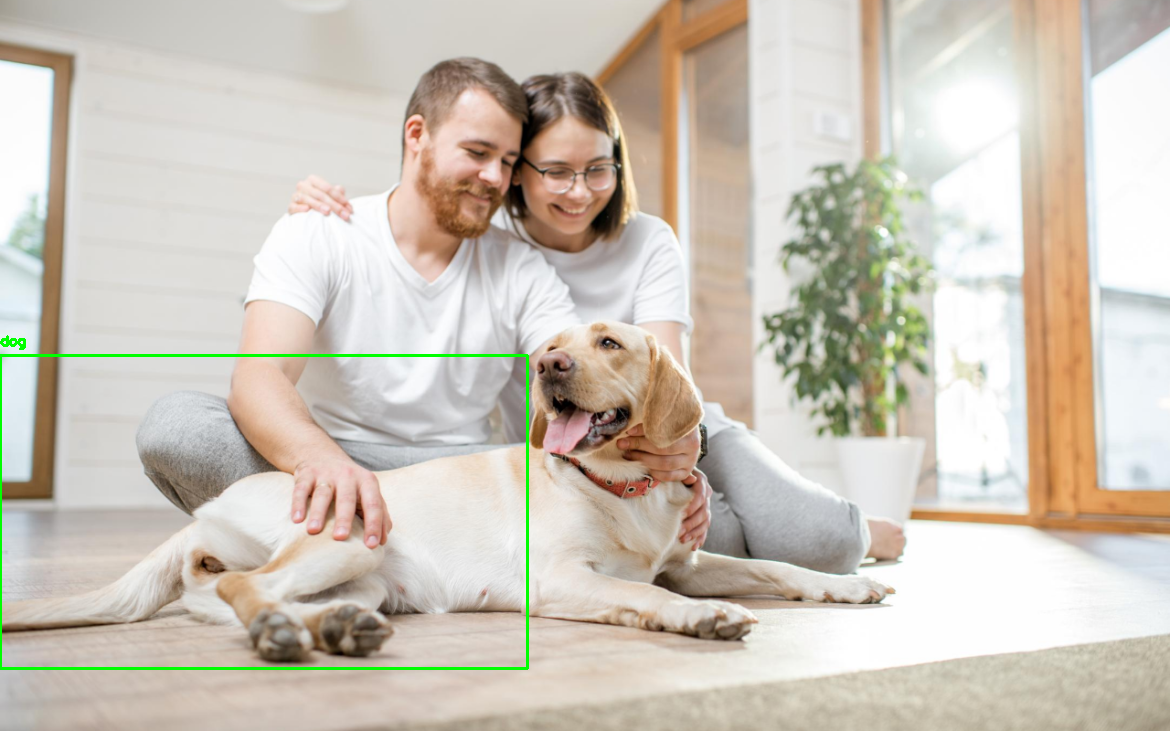

In [ ]:
# image_3 = 'https://clubpetrj.com.br/wp-content/uploads/2020/08/p%C3%B3s-pandemia-1170x731.png'

dog_clf = image_has_dog(model=model, method='fast')
dog_clf.search_dog('pós-pandemia-1170x731.png')

### CONCLUSÕES

* o método 'quality', talvez por gerar mais regiões de interesse, acaba confundindo o algoritimo
* o método 'fast' se mostrou o mais eficaz não só em relação ao tempo, mas na localização
* o algoritimo funciona bem para imagens com poucos objetos
* o algoritimo não funciona muito bem com imagens wide (16:9)

PRÓXIMOS PASSOS

- avaliar outros formatos de bounding box para encontrar a combinação que melhor se adequa ao primeiro conteúdo
- testar outros parâmetros no gridsearch